# Classifying Disaster-Related Tweets: Real or Fake?

In this project, we're taking a role as a data scientist for a news analytics company interested in monitoring and analyzing news on social media platforms, one of notable ones are Twitter, which could be handy in times of emergency.

we'll predict which Tweets are about real disasters and which aren't by builing a deep learning text classification model. The dataset comes from [Kaggle](https://www.kaggle.com/competitions/nlp-getting-started/overview). Several columns do have missing values such as `location` and `keyword`--we'll keep this in mind.

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00


In [2]:
# Import relevant libraries

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

import datasets
import transformers

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    TextVectorization, Embedding, LSTM, Dense, Bidirectional, Dropout)
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.optimizers import Adam, RMSprop

from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification

In [3]:
!wget https://dsserver-prod-resources-1.s3.amazonaws.com/nlp/train.csv
!wget https://dsserver-prod-resources-1.s3.amazonaws.com/nlp/test.csv


train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.shape)
print(train.columns)

--2024-02-24 13:18:41--  https://dsserver-prod-resources-1.s3.amazonaws.com/nlp/train.csv
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 52.217.167.145, 52.216.163.67, 3.5.25.30, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|52.217.167.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 987712 (965K) [text/csv]
Saving to: ‘train.csv’

train.csv           100%[===================>] 964.56K  3.85MB/s    in 0.2s    

2024-02-24 13:18:41 (3.85 MB/s) - ‘train.csv’ saved [987712/987712]

--2024-02-24 13:18:41--  https://dsserver-prod-resources-1.s3.amazonaws.com/nlp/test.csv
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 52.217.167.145, 52.216.163.67, 3.5.25.30, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|52.217.167.145|:443... connected.
H

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [6]:
train.sample(15, random_state=77)

,id,keyword,location,text,target
659,953,blaze,302,Yo I got bars and I'm not even a rapper,0
3216,4614,emergency%20services,NaN,Brooklyn locksmith: domesticate emergency mech...,0
3580,5115,fatal,"ÌÏT: 10.614817868480726,12.195582811791382",Boy 11 charged with manslaughter in shooting d...,1
102,146,aftershock,Instagram - @heyimginog,@afterShock_DeLo scuf ps live and the game... cya,0
4257,6049,heat%20wave,NaN,@creationsbykole cork city in Ireland...we got...,1
455,658,attack,NaN,Ûª93 blasts accused Yeda Yakub dies in Karach...,1
4699,6681,landslide,NaN,being stuck on a sleeper train for 24 hours af...,1
5670,8091,rescue,U.S.A. FEMA Region 5,Coastal German Shepherd Rescue OC shared a lin...,0
4798,6828,loud%20bang,im definitely taller than you.,I WAS PEACEFULLY SITTING IN MY ROOM AND I HEAR...,1
590,852,bioterror,"Oxford, MS",Hmm...this could be problem for some researche...,1


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
train.nunique()

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

## Data Exploration

We've seen there are a good amount of missing values. Before we deal with them, let's ask ourselves, "Do these variables contribute to predict our outcomes?" If not, we can just drop it.

In this case, `id` tells us the unique identifier, each one's different, and `location` and `keyword` would not help with the amount of unique values *and also* missing values. So we can do data cleaning and explore some more.

In [10]:
train = train.drop(['id', 'keyword', 'location'], axis=1)
train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [11]:
print(train['target'].value_counts())
print(train['target'].value_counts(normalize=True)*100)

0    4342
1    3271
Name: target, dtype: int64
0    57.034021
1    42.965979
Name: target, dtype: float64


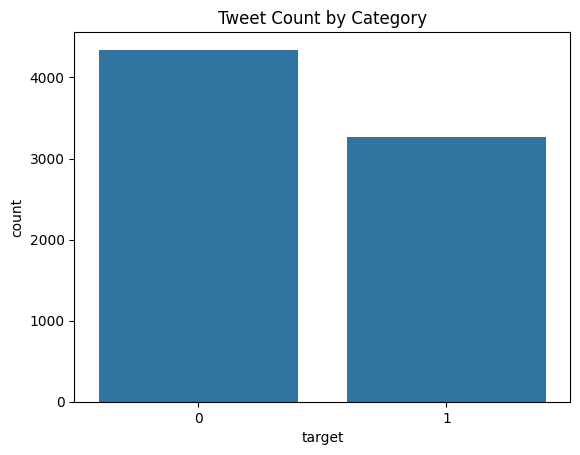

In [12]:
sns.countplot(x='target', data = train)
plt.title('Tweet Count by Category')
plt.show()

The labels look representative so far, with `4342` values of `0` and `3271` values of `1`--not that far off.

## Text Preprocessing

Before proceeding to the deep learning, we need to make sure all words included by pre-processing the text: all lowercase, only letters, with stopwords removed, and then tokenized, lemmatized, and lastly joined into a clean text.

In [13]:
# Import relevant libraries and modules
import re
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

# Making functions for data pre-processing
def strip_punctuation(inputs):
  return re.sub(r'[^\w\s]', ' ', inputs)

def tokenization(inputs):
  return word_tokenize(inputs)

stop_words = set(stopwords.words('english'))
stop_words.remove('not')
def stopwords_removed(inputs):
  return [word for word in inputs
          if word not in stop_words]

lemmatizer = WordNetLemmatizer()
def lemmatization(inputs):
  return (lemmatizer.lemmatize(word=word, pos='v') for word in inputs)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [14]:
train['text'] = train['text'].str.lower()
train['text'].head()

0    our deeds are the reason of this #earthquake m...
1               forest fire near la ronge sask. canada
2    all residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    just got sent this photo from ruby #alaska as ...
Name: text, dtype: object

In [15]:
train['text'] = train['text'].apply(strip_punctuation)
train['text'].head()

0    our deeds are the reason of this  earthquake m...
1               forest fire near la ronge sask  canada
2    all residents asked to  shelter in place  are ...
3    13 000 people receive  wildfires evacuation or...
4    just got sent this photo from ruby  alaska as ...
Name: text, dtype: object

In [16]:
train['text_tokenized'] = train['text'].apply(tokenization)
train['text_tokenized'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [13, 000, people, receive, wildfires, evacuati...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text_tokenized, dtype: object

In [17]:
train['text_stop'] = train['text_tokenized'].apply(stopwords_removed)
train['text_stop'].head()

0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, shelter, place, notified, o...
3    [13, 000, people, receive, wildfires, evacuati...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: text_stop, dtype: object

In [18]:
train['text_lemmatized'] = train['text_stop'].apply(lemmatization)
train['text_lemmatized'].head()

0    <generator object lemmatization.<locals>.<gene...
1    <generator object lemmatization.<locals>.<gene...
2    <generator object lemmatization.<locals>.<gene...
3    <generator object lemmatization.<locals>.<gene...
4    <generator object lemmatization.<locals>.<gene...
Name: text_lemmatized, dtype: object

In [19]:
train['final'] = train['text_lemmatized'].str.join(' ')
train.head()

,text,target,text_tokenized,text_stop,text_lemmatized,final
0,our deeds are the reason of this earthquake m...,1,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...",<generator object lemmatization.<locals>.<gene...,deeds reason earthquake may allah forgive us
1,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",<generator object lemmatization.<locals>.<gene...,forest fire near la ronge sask canada
2,all residents asked to shelter in place are ...,1,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...",<generator object lemmatization.<locals>.<gene...,residents ask shelter place notify officer eva...
3,13 000 people receive wildfires evacuation or...,1,"[13, 000, people, receive, wildfires, evacuati...","[13, 000, people, receive, wildfires, evacuati...",<generator object lemmatization.<locals>.<gene...,13 000 people receive wildfires evacuation ord...
4,just got sent this photo from ruby alaska as ...,1,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...",<generator object lemmatization.<locals>.<gene...,get send photo ruby alaska smoke wildfires pou...


We've looked at the table on how the text pre-processing goes. We'll be using `final` column for building the text classification models.

## Visualization with WordCloud

To look for the most used words in each label (`1` and `0`), we'll use `WordCloud` as a visual journey to get some insights on the dataset.

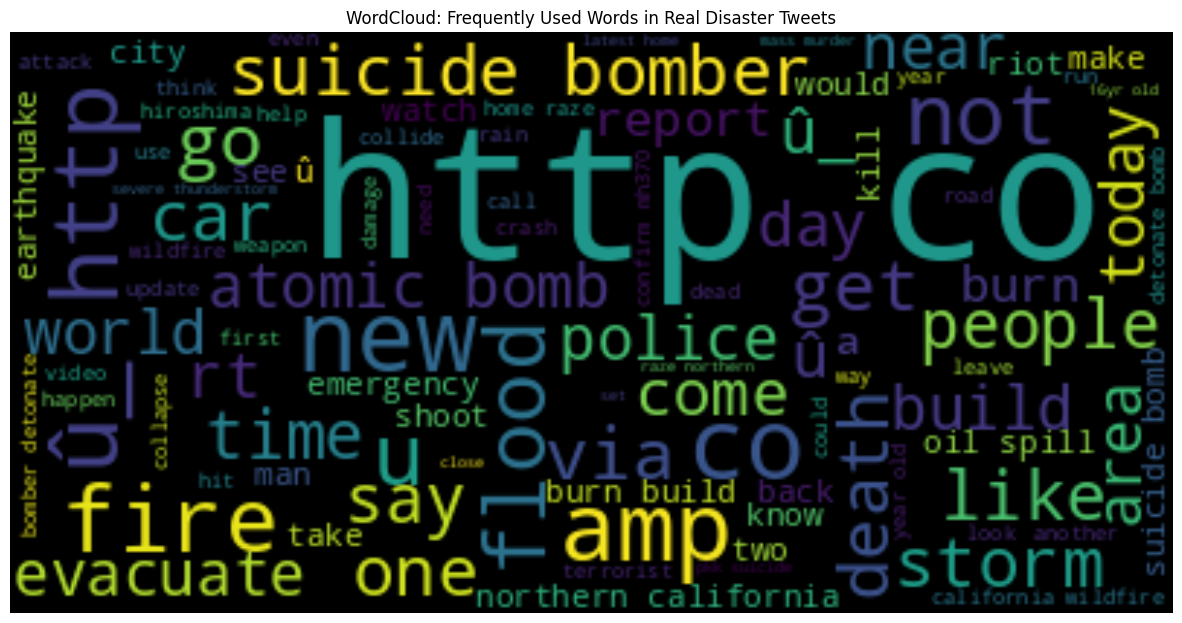

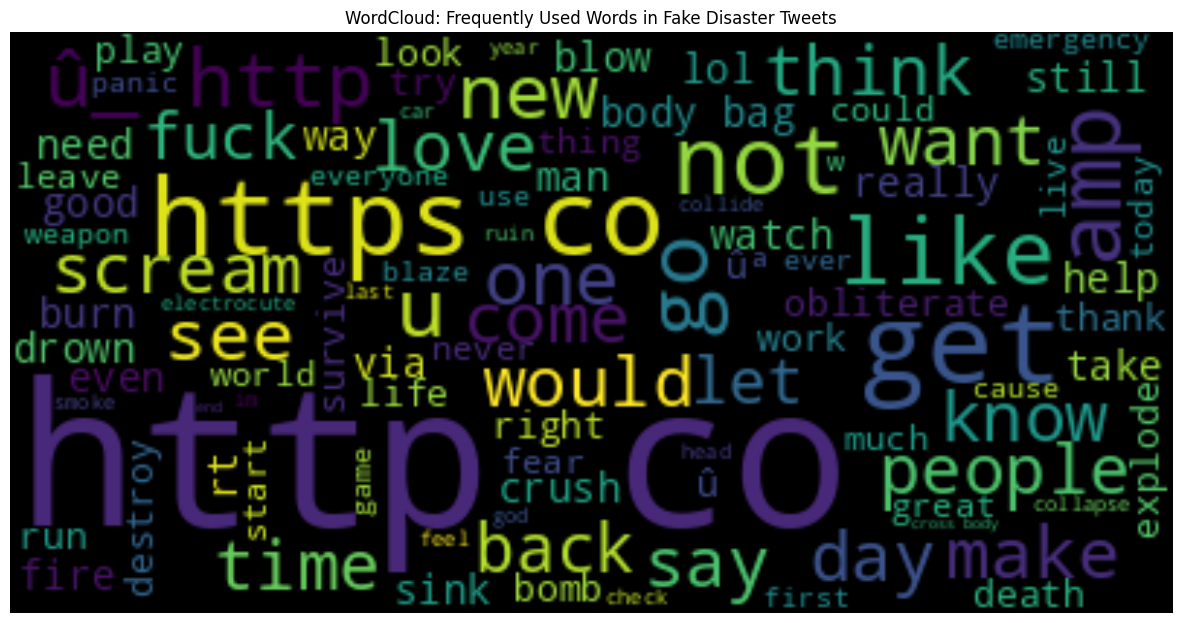

In [20]:
from wordcloud import WordCloud

# Real disaster tweets
train_1 = train[train['target'] == 1]
word_cloud_1 = WordCloud(
    max_words=100, stopwords=stop_words, random_state=100
).generate(' '.join(train_1['final'].tolist()))

# Fake disaster tweets
train_0 = train[train['target'] == 0]
word_cloud_0 = WordCloud(
    max_words=100, stopwords=stop_words, random_state=100
).generate(' '.join(train_0['final'].tolist()))

# WordCloud
plt.figure(figsize=(15, 10))
plt.imshow(word_cloud_1, interpolation='bilinear')
plt.title('WordCloud: Frequently Used Words in Real Disaster Tweets')
plt.axis('off')

plt.figure(figsize=(15, 10))
plt.imshow(word_cloud_0, interpolation='bilinear')
plt.title('WordCloud: Frequently Used Words in Fake Disaster Tweets')
plt.axis('off')

plt.show()

* The most used words in both tweets are `http` `https` `co`. This indicates that most tweets attach a link for more information.

* Seems like real disaster tweets have specific words of events attached. Take `suicide bomber`, `oil spill`, `police`, `northern california`.

* While fake disaster teets tend to have more general words like `get`, `scream`, `time`, `like`. This may indicate that our data of fake disaster tweets don't have a good weight of information inside.

## Build a Shallow Neural Network

Let's build and take some models to the test! We'll start simple by having two main layers: a vectorizer and an embedding layer, and we'll bring it up a notch. Before that, we need to split the set in `train.csv` into training and test set. We'll keep `test.csv` aside for real world data predictions.

In [21]:
X = train['final']
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 100)

print(f'Training set shape: {X_train.shape}, {y_train.shape}')
print(f'Test set shape: {X_test.shape}, {y_test.shape}')

Training set shape: (6090,), (6090,)
Test set shape: (1523,), (1523,)


In [22]:
## Relevant libraries needed (they've
## already been imported in the beginning)

# import tensorflow as tf
# import tensorflow_datasets as tfds
# from tensorflow.keras.layers import TextVectorization

max_tokens = 7500
input_length = 128
output_dim = 128

vectorizer_layer = TextVectorization(
    max_tokens = max_tokens,
    output_mode = 'int',
    standardize = 'lower_and_strip_punctuation',
    output_sequence_length = input_length
)

vectorizer_layer.adapt(X_train)

embedding_layer = Embedding(
    input_dim = max_tokens,
    output_dim = output_dim,
    input_length = input_length
)

In [23]:
# from tensorflow.keras import Input
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import (
#     TextVectorization, Embedding, LSTM, Dense, Bidirectional, Dropout)
# from tensorflow.keras.regularizers import L1, L2, L1L2
# from tensorflow.keras.optimizers import Adam, RMSprop

# Define
model = Sequential()
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorizer_layer)
model.add(embedding_layer)
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# Fit
model.fit(X_train, y_train, epochs=10, verbose=2)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test set accuracy: {test_acc}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 128)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 128, 128)          960000    
                                                                 
 dense (Dense)               (None, 128, 1)            129       
                                                                 
Total params: 960129 (3.66 MB)
Trainable params: 960129 (3.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
191/191 - 7s - loss: 0.6816 - accuracy: 0.5774 - 7s/epoch - 34ms/step
Epoch 2/10
191/191 - 3s - loss: 0.6772 - accuracy: 0.5843 - 3s/epoch - 18ms/step
Epoch 3/10
191/191 - 3s - loss: 0.6747 - accuracy: 0.584

We got training and test set accuracy of both `58.28%`--could've been better with several optimization.

## Build a Multi-layer Deep Text Classification Model

Here we'll be adding several fancy techniques like `GlobalAveragePooling1D()`, regularization parameter of `kernel_regularizer` in `Dense` layer, and `Dropout` layers to the model architecture.

In [24]:
### Copied from previous block of code:

# from tensorflow.keras import Input
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import (
#     TextVectorization, Embedding, LSTM, Dense, Bidirectional, Dropout)
# from tensorflow.keras.regularizers import L1, L2, L1L2
# from tensorflow.keras.optimizers import Adam, RMSprop

# Define + Optimize; add several layers, changing several parameters
model_reg = Sequential()
model_reg.add(Input(shape=(1,), dtype=tf.string))
model_reg.add(vectorizer_layer)
model_reg.add(embedding_layer)

model_reg.add(Dense(128, activation='relu',
  kernel_regularizer=  L1(l1=0.0005)))
model_reg.add(Dropout(rate=0.6))

model_reg.add(Dense( 64, activation='relu',
  kernel_regularizer=L1L2(l1=0.0005, l2=0.0005)))

model_reg.add(Dense( 32, activation='relu',
  kernel_regularizer=  L2(l2=0.0005)))

model_reg.add(Dense( 16, activation='relu',
  kernel_regularizer=  L2(l2=0.0005)))

model_reg.add(Dense( 8, activation='relu',
  kernel_regularizer=  L2(l2=0.0005)))

model_reg.add(Dense(1, activation='sigmoid'))

# Compile -- changing parameters
model_reg.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy', metrics=['accuracy'])

model_reg.summary()

# Fit
model_reg.fit(X_train, y_train, epochs=10)

# Evaluate
test_loss, test_acc = model_reg.evaluate(X_test, y_test)
print(f'Test set accuracy: {test_acc}')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 128)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 128, 128)          960000    
                                                                 
 dense_1 (Dense)             (None, 128, 128)          16512     
                                                                 
 dropout (Dropout)           (None, 128, 128)          0         
                                                                 
 dense_2 (Dense)             (None, 128, 64)           8256      
                                                                 
 dense_3 (Dense)             (None, 128, 32)           2080      
                                                      

We get that the model still has less accuracy in both training and test set: `57.00%` and `57.19%`--This may be due to the nature of text that is a sequential data, where a tokenized word relates to the other--before and after it.

We can use a technique of `Bidirectional` and `LSTM` to handle this text nature of classification.

## Building a Multi-Layer Bidirectional LSTM Model

In [25]:
### Copied from previous block of code:

# from tensorflow.keras import Input
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import (
#     TextVectorization, Embedding, LSTM, Dense, Bidirectional, Dropout)
# from tensorflow.keras.regularizers import L1, L2, L1L2
# from tensorflow.keras.optimizers import Adam, RMSprop

# Define + Optimize; add several layers, changing several parameters
model_ml_bi_lstm = Sequential()
model_ml_bi_lstm.add(Input(shape=(1,), dtype=tf.string))
model_ml_bi_lstm.add(vectorizer_layer)
model_ml_bi_lstm.add(embedding_layer)

# Add 2 layers of Bidirectional(LSTM(...))
# Activation parameter changed from 'relu' to 'elu'

model_ml_bi_lstm.add(Bidirectional(LSTM(128,
  activation='relu', return_sequences=True)))

model_ml_bi_lstm.add(Bidirectional(LSTM(128,
  activation='relu', return_sequences=True)))

model_ml_bi_lstm.add(Bidirectional(LSTM(64)))

model_ml_bi_lstm.add(Dense( 64, activation='elu',
  kernel_regularizer=L1L2(l1=0.0001, l2=0.0001)))

model_ml_bi_lstm.add(Dense( 32, activation='elu',
  kernel_regularizer=  L2(l2=0.0001)))

model_ml_bi_lstm.add(Dense(  8, activation='elu',
  kernel_regularizer=  L2(l2=0.0005)))

model_ml_bi_lstm.add(Dense(  8, activation='elu',
  kernel_regularizer=  L2(l2=0.0005)))

model_ml_bi_lstm.add(Dense(  8, activation='elu'))
model_ml_bi_lstm.add(Dense(  4, activation='elu'))

model_ml_bi_lstm.add(Dense(1, activation='sigmoid'))

# Compile -- changing parameters
model_ml_bi_lstm.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy', metrics=['accuracy'])

model_ml_bi_lstm.summary()

# Fit
model_ml_bi_lstm.fit(X_train, y_train, epochs=10)

# Evaluate
test_loss, test_acc = model_ml_bi_lstm.evaluate(X_test, y_test)
print(f'Test set accuracy: {test_acc}')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 128)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 128, 128)          960000    
                                                                 
 bidirectional (Bidirection  (None, 128, 256)          263168    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128, 256)          394240    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               164352    
 onal)                                                

After applying `Bidirectional` and `LSTM`, we found a great accuracy of `95.14%` in training set and `78.59%` in test set. It's a pretty good improvement from the last 2 models.

## Building a Transformer Model

Now we can try another more efficient option by using `transformers`. In this module we have a good bunch of options for tokenizing words, and here we'll be using `'distilbert-base-uncased'`. You can look for more options of pre-trained models [here](https://huggingface.co/models).

In [27]:
!pip install transformers

In [28]:
# from transformer import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Findings: Characteristics of 'distilbert-base-uncased':
## is_fast = True : A Rust-based tokenizer; more efficient than Python
## model_max_length = 512       ## vocab_size = 30522

tokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [30]:
# Max Length: 128 sequences,
# Truncation: Text pruned to amaximum length when
#             surpasses model's max input length
# Padding : When sequence < 128, the rest is filled
#           with padding tokens so all length's the same.

# Tokenize both training and test data
train_encodings = tokenizer(list(X_train),
  max_length=128, truncation=True, padding=True)
test_encodings = tokenizer(list(X_test),
  max_length=128, truncation=True, padding=True)

In [31]:
# Convert the data into TensorFlow datasets for more effective computation

train_dataset = tf.data.Dataset.from_tensor_slices(
    ( dict(train_encodings), tf.constant(y_train, dtype=tf.int32) )
)

test_dataset = tf.data.Dataset.from_tensor_slices(
    ( dict(test_encodings), tf.constant(y_test, dtype=tf.int32) )
)

# Shuffle the `train`, not `test` (for real-world data predictions),
# and batch both to improve training efficiency of model.
train_dataset = train_dataset.shuffle(len(X_train)).batch(16)
test_dataset  = test_dataset.batch(16)

In [33]:
# from transformers import TFAutoModelForSequenceClassification

model_distilbert = (
    TFAutoModelForSequenceClassification
        .from_pretrained('distilbert-base-uncased', num_labels=2))

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]
optimizer = Adam(learning_rate=3e-5)

# Compile the model
model_distilbert.compile(
    loss=loss, metrics=metrics, optimizer=optimizer)

model_distilbert.summary()

model_distilbert.fit(train_dataset, epochs=10,
                     validation_data=train_dataset)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_40 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
381/381 [========================

After modifying the model to `AutoTokenizer` of `distilbert-base-uncased`, we have accuracies of `98.19%` in training set, validated with the same set with an accuracy of 98.78%.

## Conclusion:

We've built a text classification model with accuracy comparison as follows:

**) Tested with validation from training set*

| Model    | `model` | `model_reg` | `model_ml_bi_lstm`   | `model_distilbert`  |
|----------|---------|-------------|-----------|----------|
| Training Accuracy | `58.28%`  |   `57.00%`    |   `95.14%`  |    `98.19%`   |
| Test Accuracy | `58.28%`  |   `57.19%`    |   `78.59%`  |    `98.78%*`   |

Using a pre-trained model in `transformers` create an improved accuracy compared to other models in text classification of disaster-related tweets. We can use it to predict real-world data of real or fake tweets to come.